# Project 3: Web APIs and NLP <br>

#### Brandie Hatch

### Modeling

## Imports, Data Reading, and Model Prep

In [70]:
# python library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC, SVC 
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline
pd.options.display.max_columns =999


In [6]:
# Read in Data

df = pd.read_csv('../data/prepped.csv', index_col=False)
print(df.shape)
df.head()

(9436, 11)


,num_comments,score,selftext,subreddit,title,text,title_length,title_word_count,selftext_length,selftext_word_count,subreddit_num
0,2,1,The wife and I adopted a 1 to 3 year old beagl...,Dogtraining,Rescue dog will not come inside from fenced in...,Rescue dog will not come inside from fenced in...,51,10,986,203,1
1,1,1,I have an 8 month old Rottweiler puppy who is ...,Dogtraining,“Drop it” fails,“Drop it ” fails I have an 8 month old Rottwei...,15,3,1056,207,1
2,1,1,Long story short we used to have two dogs. A d...,Dogtraining,My dog will ONLY submissive pee.,My dog will ONLY submissive pee . Long story s...,32,6,732,147,1
3,1,1,I’ve recently adopted a golden retriever! He’s...,Dogtraining,Separation anxiety in dog used to living in a ...,Separation anxiety in dog used to living in a ...,51,10,573,112,1
4,1,1,**TLDR:** Do you leave your dog unsupervised ...,Dogtraining,"So, is my backyard making my dog more reactive?","So , is my backyard making my dog more reactiv...",47,9,1866,330,1


In [7]:
# imported data split between two subreddits
df['subreddit'].value_counts(normalize=True)

Dogtraining     0.500424
service_dogs    0.499576
Name: subreddit, dtype: float64

In [8]:
# Create X and y using StandardScaler to scale values

X = df.drop(columns=['subreddit', 'subreddit_num', 'title', 'selftext'])
y = df['subreddit_num']

In [9]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [10]:
# calculate the baseline accuracy (% of the majority class, dogtraining)
# benchmark to beat is .502732
y.value_counts(normalize=True)

1    0.500424
0    0.499576
Name: subreddit_num, dtype: float64

## Modeling

### Random Forest Classifier

In [11]:
# column transformer, countvectorizer needs to only go to the text columns
col_trans = ColumnTransformer([
    ('cvex', CountVectorizer(lowercase=True, stop_words={'english'}), 'text'),
    ('ss', StandardScaler(), ['score', 'num_comments', 'title_length', 'title_word_count', 'selftext_length', 'selftext_word_count'])],
    remainder='passthrough',
    sparse_threshold=0
)

In [12]:
col_trans.fit(X_train)

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('cvex',
                                 CountVectorizer(stop_words={'english'}),
                                 'text'),
                                ('ss', StandardScaler(),
                                 ['score', 'num_comments', 'title_length',
                                  'title_word_count', 'selftext_length',
                                  'selftext_word_count'])])

In [13]:
col_trans.transform(X_train)

array([[ 0.        ,  0.        ,  0.        , ...,  0.00784865,
         4.03839705,  4.09657099],
       [ 0.        ,  0.        ,  0.        , ..., -1.03943033,
        -0.64380322, -0.69326259],
       [ 0.        ,  0.        ,  0.        , ..., -1.21397682,
        -0.42467672, -0.47383304],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.18239514,
         0.15334345,  0.12803087],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
        -0.24345318, -0.22932583],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
         1.15421854,  1.16875387]])

In [27]:
# pipeline StandardScaler + instantiate RandomForestClassifier
pipe = Pipeline([
    ('col_trans', col_trans),
    ('rf', RandomForestClassifier())
])

In [28]:
params = {
    'rf__n_estimators': [1, 100, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5]
}
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9554882664647995


{'rf__max_depth': None, 'rf__n_estimators': 200}

In [29]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(1.0, 0.9530201342281879)

In [66]:
pd.Series(gs.predict(X_test)).value_counts()

1    1438
0    1393
dtype: int64

### Decision Tree Classifier


In [31]:
# column transformer, countvectorizer needs to only go to the text columns
col_trans_tree = ColumnTransformer([
    ('cvex', CountVectorizer(lowercase=True, stop_words={'english'}), 'text'),
    ('ss', StandardScaler(), ['score', 'num_comments', 'title_length', 'title_word_count', 'selftext_length', 'selftext_word_count'])],
    remainder='passthrough',
    sparse_threshold=0
)

In [32]:
col_trans_tree.fit(X_train)

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('cvex',
                                 CountVectorizer(stop_words={'english'}),
                                 'text'),
                                ('ss', StandardScaler(),
                                 ['score', 'num_comments', 'title_length',
                                  'title_word_count', 'selftext_length',
                                  'selftext_word_count'])])

In [33]:
col_trans_tree.transform(X_train)

array([[ 0.        ,  0.        ,  0.        , ...,  0.00784865,
         4.03839705,  4.09657099],
       [ 0.        ,  0.        ,  0.        , ..., -1.03943033,
        -0.64380322, -0.69326259],
       [ 0.        ,  0.        ,  0.        , ..., -1.21397682,
        -0.42467672, -0.47383304],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.18239514,
         0.15334345,  0.12803087],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
        -0.24345318, -0.22932583],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
         1.15421854,  1.16875387]])

In [34]:
# pipeline StandardScaler + instantiate decision tree classifier
pipe_tree = Pipeline([
    ('col_trans_tree', col_trans_tree),
    ('tree', DecisionTreeClassifier())
])

In [35]:
params_tree = {
    'tree__random_state': [1, 2],
    'tree__max_depth': [None, 1, 2, 3]
}
tree_gs = GridSearchCV(pipe_tree, param_grid=params_tree, cv=5)
tree_gs.fit(X_train, y_train)
print(tree_gs.best_score_)
tree_gs.best_params_

0.953217259651779


{'tree__max_depth': None, 'tree__random_state': 1}

In [36]:
tree_gs.score(X_train, y_train), tree_gs.score(X_test, y_test)

(1.0, 0.949134581419993)

In [37]:
pd.Series(tree_gs.predict(X_test)).value_counts()

1    1423
0    1408
dtype: int64

### Logistic Regression

In [39]:
# pipeline StandardScaler + instantiate RandomForestClassifier
pipe_log = Pipeline([
    ('col_trans', col_trans),
    ('log_reg', LogisticRegression())
])

In [40]:
params_log = {
    'log_reg__penalty': ['l2', 'elasticnet'],
    'log_reg__C': [1, 2]
}
log_gs = GridSearchCV(pipe_log, param_grid=params_log, cv=5)
log_gs.fit(X_train, y_train)
print(log_gs.best_score_)
log_gs.best_params_

c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

0.9654806964420892


c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'log_reg__C': 1, 'log_reg__penalty': 'l2'}

In [41]:
log_gs.score(X_train, y_train), log_gs.score(X_test, y_test)

(0.9998485995457986, 0.9678558813140233)

In [42]:
pd.Series(log_gs.predict(X_test)).value_counts()

1    1446
0    1385
dtype: int64

### Support Vector Machines (SVM): Linear SVC & C-Support Vector Classification

In [48]:
# define linspace variable
pgrid = ['C', np.linspace(0.0001, 1, 20)]

In [49]:
# pipeline StandardScaler + instantiate RandomForestClassifier
pipe_svm = Pipeline([
    ('col_trans', col_trans),
    ('ln_svc', LinearSVC())
])

In [51]:
# instantiate and fit gridsearch

params_svm = {
    'ln_svc__max_iter': [5000, 10000]
}
gs_svm = GridSearchCV(pipe_svm, param_grid=params_svm, cv=5)
gs_svm.fit(X_train, y_train)
print(gs_svm.best_score_)
gs_svm.best_params_


#gs_svm = GridSearchCV(LinearSVC(max_iter=5000), pgrid)

#gs_svm.fit(X, y)

0.9609386828160484


{'ln_svc__max_iter': 5000}

In [52]:
gs_svm.score(X_train, y_train), gs_svm.score(X_test, y_test)

(1.0, 0.9629106322854115)

In [53]:
pd.Series(gs_svm.predict(X_test)).value_counts()

1    1440
0    1391
dtype: int64

### SVM: C-Support Vector Classification

In [20]:
# pipeline StandardScaler + instantiate decision tree classifier
pipe_svc = Pipeline([
    ('col_trans_tree', col_trans_tree),
    ('svc', SVC())
])

In [21]:

pgrid_svc = {
    'svc__C': [1, 2],
    'svc__kernel': ['poly'],
    'svc__degree': [2],
    'svc__gamma': ['scale'] 
}
gs_svc = GridSearchCV(pipe_svc, param_grid=pgrid_svc, cv=5)
gs_svc.fit(X_train, y_train)
print(gs_svc.best_score_)
gs_svc.best_params_

0.8996214988644965


{'svc__C': 2, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

In [64]:
gs_svc.score(X_train, y_train), gs_svc.score(X_test, y_test)

(0.9330809992429977, 0.9145178382197103)

In [65]:
pd.Series(gs_svc.predict(X_test)).value_counts()

0    1568
1    1263
dtype: int64

## Model Evaluation & Comparison

### Confusion Matrix Displays

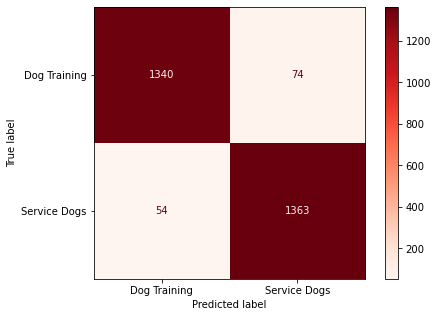

In [129]:
# Random Forest Classifier
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    gs, 
    X_test, 
    y_test, 
    display_labels=['Dog Training', 'Service Dogs'], 
    cmap='Reds',
    ax=ax
);

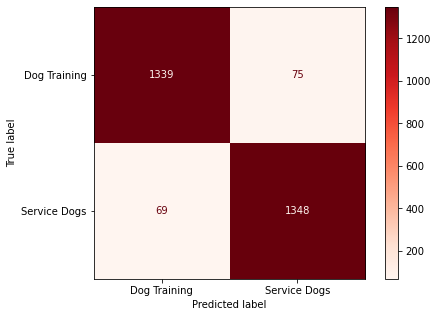

In [130]:
# Decision Tree Classifier
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    tree_gs, 
    X_test, 
    y_test, 
    display_labels=['Dog Training', 'Service Dogs'], 
    cmap='Reds',
    ax=ax
);

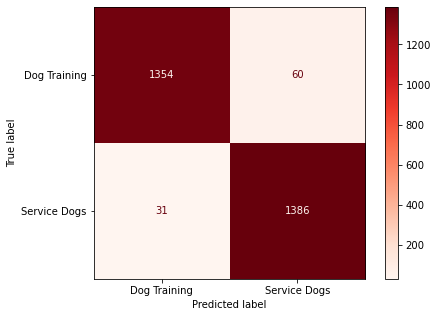

In [131]:
# Logisitic Regression
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(log_gs,
                                      X_test,
                                      y_test,
                                      display_labels=['Dog Training', 'Service Dogs'], 
                                      cmap='Reds', 
                                      ax=ax);

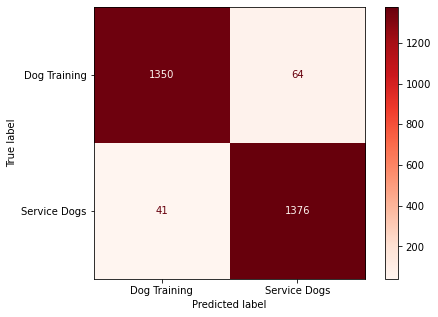

In [128]:
# SVM 
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(gs_svm,
                                      X_test,
                                      y_test,
                                      display_labels=['Dog Training', 'Service Dogs'], 
                                      cmap='Reds', 
                                      ax=ax);

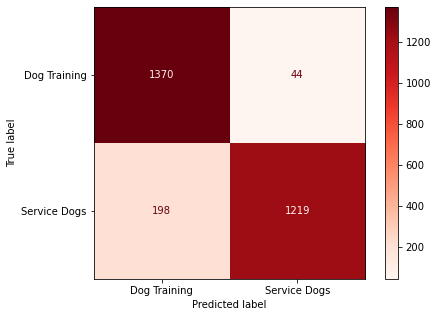

In [23]:
# SVC
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(gs_svc,
                                      X_test,
                                      y_test,
                                      display_labels=['Dog Training', 'Service Dogs'], 
                                      cmap='Reds', 
                                      ax=ax);

In [54]:
print('Random Forest Classifier')
print(gs.best_score_)
print(gs.best_params_)
print('Decision Tree Classifier')
print(tree_gs.best_score_)
print(tree_gs.best_params_)
print('Logistic Regression')
print(log_gs.best_score_)
print(log_gs.best_params_)
print('SVM: Linear SVC')
print(gs_svm.best_score_)
print(gs_svm.best_params_)
print('SVM: C-Support Vector Classification')
print(gs_svc.best_score_)
print(gs_svc.best_params_)

Random Forest Classifier
0.9554882664647995
{'rf__max_depth': None, 'rf__n_estimators': 200}
Decision Tree Classifier
0.953217259651779
{'tree__max_depth': None, 'tree__random_state': 1}
Logistic Regression
0.9654806964420892
{'log_reg__C': 1, 'log_reg__penalty': 'l2'}
SVM: Linear SVC
0.9609386828160484
{'ln_svc__max_iter': 5000}
SVM: C-Support Vector Classification
0.8996214988644965
{'svc__C': 2, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}


In [55]:
# Accuracy score
print('Random Forest Classifier')
print(accuracy_score(y_test, gs.predict(X_test)))
print('Decision Tree Classifier')
print(accuracy_score(y_test, tree_gs.predict(X_test)))
print('Logistic Regression')
print(accuracy_score(y_test, log_gs.predict(X_test)))
print('SVM: Linear SVC')
print(accuracy_score(y_test, gs_svm.predict(X_test)))
print('SVM: C-Support Vector Classification')
print(accuracy_score(y_test, gs_svc.predict(X_test)))

Random Forest Classifier
0.9530201342281879
Decision Tree Classifier
0.949134581419993
Logistic Regression
0.9678558813140233
SVM: Linear SVC
0.9629106322854115
SVM: C-Support Vector Classification
0.9145178382197103


In [56]:
# ROC Accuracy score
print('Random Forest Classifier')
print(roc_auc_score(y_test, gs.predict(X_test)))
print('Decision Tree Classifier')
print(roc_auc_score(y_test, tree_gs.predict(X_test)))
print('Logistic Regression')
print(roc_auc_score(y_test, log_gs.predict(X_test)))
print('SVM: Linear SVC')
print(roc_auc_score(y_test, gs_svm.predict(X_test)))
print('SVM: C-Support Vector Classification')
print(roc_auc_score(y_test, gs_svc.predict(X_test)))

Random Forest Classifier
0.9530122207704186
Decision Tree Classifier
0.9491322783856166
Logistic Regression
0.9678449899632569
SVM: Linear SVC
0.9629019812960226
SVM: C-Support Vector Classification
0.9145753873703732


In [57]:
# Precision score
print('Random Forest Classifier')
print(precision_score(y_test, gs.predict(X_test)))
print('Decision Tree Classifier')
print(precision_score(y_test, tree_gs.predict(X_test)))
print('Logistic Regression')
print(precision_score(y_test, log_gs.predict(X_test)))
print('SVM: Linear SVC')
print(precision_score(y_test, gs_svm.predict(X_test)))
print('SVM: C-Support Vector Classification')
print(precision_score(y_test, gs_svc.predict(X_test)))

Random Forest Classifier
0.9464534075104312
Decision Tree Classifier
0.9472944483485594
Logistic Regression
0.9585062240663901
SVM: Linear SVC
0.9555555555555556
SVM: C-Support Vector Classification
0.9651623119556612


In [58]:
# Recall score
print('Random Forest Classifier')
print(recall_score(y_test, gs.predict(X_test)))
print('Decision Tree Classifier')
print(recall_score(y_test, tree_gs.predict(X_test)))
print('Logistic Regression')
print(recall_score(y_test, log_gs.predict(X_test)))
print('SVM: Linear SVC')
print(recall_score(y_test, gs_svm.predict(X_test)))
print('SVM: C-Support Vector Classification')
print(recall_score(y_test, gs_svc.predict(X_test)))

Random Forest Classifier
0.9604798870853917
Decision Tree Classifier
0.9513055751587862
Logistic Regression
0.9781227946365562
SVM: Linear SVC
0.9710656316160904
SVM: C-Support Vector Classification
0.8602681721947777


In [59]:
# Specificity score
print('Random Forest Classifier')
print(recall_score(y_test, gs.predict(X_test), pos_label=0))
print('Decision Tree Classifier')
print(recall_score(y_test, tree_gs.predict(X_test), pos_label=0))
print('Logistic Regression')
print(recall_score(y_test, log_gs.predict(X_test), pos_label=0))
print('SVM: Linear SVC')
print(recall_score(y_test, gs_svm.predict(X_test), pos_label=0))
print('SVM: C-Support Vector Classification')
print(recall_score(y_test, gs_svc.predict(X_test), pos_label=0))

Random Forest Classifier
0.9455445544554455
Decision Tree Classifier
0.946958981612447
Logistic Regression
0.9575671852899575
SVM: Linear SVC
0.9547383309759547
SVM: C-Support Vector Classification
0.9688826025459689


In [60]:
# F1 score
print('Random Forest Classifier')
print(f1_score(y_test, gs.predict(X_test)))
print('Decision Tree Classifier')
print(f1_score(y_test, tree_gs.predict(X_test)))
print('Logistic Regression')
print(f1_score(y_test, log_gs.predict(X_test)))
print('SVM: Linear SVC')
print(f1_score(y_test, gs_svm.predict(X_test)))
print('SVM: C-Support Vector Classification')
print(f1_score(y_test, gs_svc.predict(X_test)))

Random Forest Classifier
0.953415061295972
Decision Tree Classifier
0.9492957746478874
Logistic Regression
0.9682151589242054
SVM: Linear SVC
0.9632481624081205
SVM: C-Support Vector Classification
0.9097014925373135


In [61]:
print(y_train.mean(), y_test.mean())

0.5003785011355034 0.5005298481102084


In [62]:
y_test.sum()/y_test.count()

0.5005298481102084

In [63]:
y_test.value_counts(normalize=True)

1    0.50053
0    0.49947
Name: subreddit_num, dtype: float64

## Answer Problem, Conclusions, and Recommendations

__Answer based on the following conclusions:__ Overall, the Logistic Regression model was the best model to identify Service Dogs vs Dog Training Subreddits. The SVM: C-Support Vector Classification model could also be used since it was very close in a lot of ways also. 

| Variable | Model                                | Best Score (gridsearch) | Train Score       | Test Score        | Accuracy          | ROC Accuracy      | Precision         | Recall            | Specificity       | F1 Score          |
|----------|--------------------------------------|-------------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|-------------------|
| gs       | Random Forest Classifier             | 0.952763058289175       | 1.000000000000000 | 0.953020134228187 | 0.953020134228187 | 0.953012220770418 | 0.946453407510431 | 0.960479887085391 | 0.945544554455445 | 0.953415061295972 |
| tree_gs  | Decision Tree Classifier             | 0.953217259651779       | 1.000000000000000 | 0.949134581419993 | 0.949134581419993 | 0.949132278385616 | 0.947294448348559 | 0.951305575158786 | 0.946958981612447 | 0.949295774647887 |
| log_gs   | Logistic Regression                  | 0.965480696442089       | 0.999848599545798 | 0.967855881314023 | 0.967855881314023 | 0.967844989963256 | 0.958506224066390 | 0.978122794636556 | 0.957567185289957 | 0.968215158924205 |
| gs_svm   | SVM: Linear SVC                      | 0.960938682816048       | 1.000000000000000 | 0.962910632285411 | 0.962910632285411 | 0.962901981296022 | 0.955555555555555 | 0.971065631616090 | 0.954738330975954 | 0.963248162408120 |
| gs_svc   | SVM: C-Support Vector Classification | 0.899621498864496       | 0.933080999242997 | 0.914517838219710 | 0.914517838219710 | 0.914575387370373 | 0.965162311955661 | 0.860268172194777 | 0.968882602545968 | 0.909701492537313 |

In [68]:
# Difference between the Train Score and Test Score of the SVM: C-Support Vector Classification 
0.933080999242997 - 0.914517838219710

0.018563161023287034

In [69]:
# Difference between the Train Score and Test Score of the Logistic Regression model
0.999848599545798 - 0.967855881314023

0.031992718231774964

### Findings

__Bias/Variance Tradeoff__ All of the models were overfit where the train score was higher than the test score. The *Logistic Regression* model was the least overfit and performed the best in the tradeoff because it had the highest train/test scores. The *SVM: C-Support Vector Classification* was a close second because the difference between the train and test scores was the lowest. <br>  

__Accuracy__ Number of correct predictions divided by the total number of predications, multiplied by 100 to get percentage: *Logistic Regression* had the best accuracy because it predicted the correct Subreddit 96.7% of the time. This is a reliable indicator because of the basically even class distribution.<br>

__Precision__ Number of true positives divided by the number of true positives plus the false positives: *SVM: C-Support Vector Classification* had the best precision with 96.1% precisely predicted the correct Subreddit. This is not the best indicator because of the even class distribution. Precision in this situation is showing us how many submissions that were predicted as being correct and actually were correct.<br>

__Recall__ Fraction of samples from a class which are correctly predicted by the model: *Logistic Regression* had the best recall because of the correctly labeled Subreddits, the model predicted 97.8% correct. <br>

__Specificity__ Fraction of samples from a class which are incorrectly predicted as incorrect (True negative rate): *SVM: C-Support Vector Classification* had the best recall because of the incorrectly labeled Subreddits, the model predicted those correctly incorrect at 96.8%. This is not a reliable indicator in this specific situation. <br>

__F1 Score__ Combination of precision and recall to check on the balance of the two: *Logistic Regression* has the highest F1 Score, so therefore, is the most balanced of the models.

c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


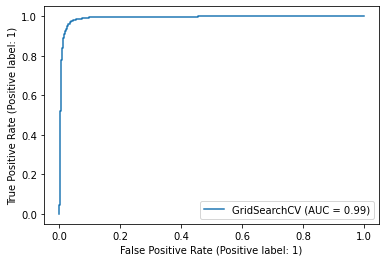

In [74]:
# Plot Roc Curve for Logistic Regression
plot_roc_curve(log_gs, X_test, y_test);

c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


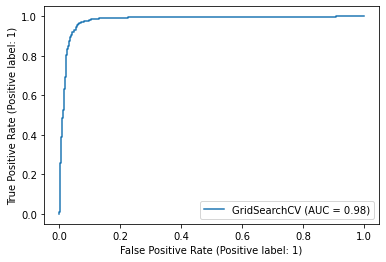

In [73]:
# Plot Roc Curve for Logistic Regression
plot_roc_curve(gs_svc, X_test, y_test);

### Recommendations

__Implications__ Even though the Logistic Regression model was the most accurate at predicting the difference between the Service Dogs and Dog Training Subreddits, the classifications offered little to help predict training opportunities for service and other dogs. Classification opportunities could be to look more into the most common words and compare the differences between each Subreddit. <br>

__Next Steps__ Specifically looking for training theories and pedagogy related words could be a valuable opportunity in the future.


## Sources

https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce